## Chicago Chain Runs
#### 10 Wards Out Of Community Areas

This notebook performs the following chain run:
- Out of Community Areas:
    - 10 wards of equal population
        - Population deviation tolerance of 5%

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from functools import partial
import pickle
import geopandas
from tqdm import tqdm
import pathlib
from gerrychain.random import random
import gerrychain as gc
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from gerrychain import accept
from gerrychain.tree import bipartition_tree, predecessors, random_spanning_tree
import json

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
# Create the graph
df = geopandas.read_file("../shapefiles/chicago_comareas_economic.shp").set_index("area_num_1")
precincts = gc.Graph.from_geodataframe(df, reproject=False)
precincts.add_data(df)

## Generating a seed plan with < 5% deviation

In [3]:
def recursive_tree_part(graph, parts, pop_col, epsilon, node_repeats=18):
    """Uses :func:`~gerrychain.tree_methods.bipartition_tree` recursively to partition a tree into
    ``len(parts)`` parts of population ``pop_target`` (within ``epsilon``). Can be used to
    generate initial seed plans or to implement ReCom-like "merge walk" proposals.
    :param graph: The graph
    :param parts: Iterable of part labels (like ``[0,1,2]`` or ``range(4)``
    :param pop_target: Target population for each part of the partition
    :param pop_col: Node attribute key holding population data
    :param epsilon: How far (as a percentage of ``pop_target``) from ``pop_target`` the parts
        of the partition can be
    :param node_repeats: Parameter for :func:`~gerrychain.tree_methods.bipartition_tree` to use.
    :return: New assignments for the nodes of ``graph``.
    :rtype: dict
    """
    flips = {}
    remaining_nodes = set(graph.nodes)
    
    total_pop = sum(graph.nodes[node][pop_col] for node in graph)
    remaining_pop = total_pop
    ideal_pop = total_pop / len(parts)
    pop_target = ideal_pop
    initial_epsilon = epsilon
    
    for i, part in enumerate(parts[:-1]):
        pop_target = remaining_pop / (len(parts) - i)
        nodes = bipartition_tree(
            graph.subgraph(remaining_nodes), pop_col, pop_target, epsilon, node_repeats
        )

        for node in nodes:
            flips[node] = part
        remaining_pop -= sum(graph.nodes[node][pop_col] for node in nodes)
        remaining_nodes -= nodes

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

    return flips

In [4]:
# Create an initial plan that does not violate population constraints
num_partitions = 10
pop_col = "TOTPOP"

# This modified recursive_tree_part manages to get below 5% deviation if
# you ask for 3%
assignment = recursive_tree_part(
    precincts,
    parts=range(num_partitions),
    pop_col=pop_col,
    epsilon=0.03,
)

In [12]:
with open("./ca10/initial_assignment.json", "w") as f:
    json.dump(assignment, f)

## Running the chain

In [4]:
with open("./ca10/initial_assignment.json") as f:
    assignment = json.load(f)

In [5]:
# Create an election object and updaters
# election = gc.Election("M15", ["Emanuel_M1", "Wilson_M15", "Fioretti_M", "Garcia_M15", "Walls_M15"])

updaters = {"population": gc.updaters.Tally("TOTPOP", alias="population"), "cut_edges": gc.updaters.cut_edges}
variables = [
    "TOTPOP", "HISP", "NH_WHITE", "NH_BLACK", "NH_ASIAN",
    "VAP", "HVAP", "WVAP", "BVAP", "ASIANVAP",'TOTHH', 'LESS_10K', '10K_15K', '15K_20K', '20K_25K',
       '25K_30K', '30K_35K', '35K_40K', '40K_45K', '45K_50K', '50K_60K',
       '60K_75K', '75K_100K', '100K_125K', '125K_150K', '150K_200K',
       '200K_MORE'
]
attrs = {key: gc.updaters.Tally(key, alias=key) for key in variables}
updaters.update(attrs)

# Create an initial partition
initial = gc.Partition(
    precincts,
    assignment=assignment,
    updaters=updaters)

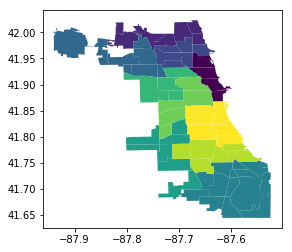

In [14]:
initial.plot(df)

In [15]:
max(map(abs, gc.constraints.validity.deviation_from_ideal(initial).values()))

0.03385278213892028

In [16]:
pop_target = df.TOTPOP.sum() / 10
pop_col = "TOTPOP"

In [17]:
# Configure the ReCom proposal and constraints
proposal_10 = partial(recom,
                      pop_col=pop_col,
                      pop_target=pop_target,
                      epsilon=0.05,
                      node_repeats=10)

compactness_bound = gc.constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2 * len(initial["cut_edges"]))

population_constraint = gc.constraints.within_percent_of_ideal_population(initial, 0.05)

In [18]:
# Configure the Markov Chain
chain_CA = gc.MarkovChain(
    proposal=proposal_10,
    constraints=[compactness_bound, population_constraint],
    accept=accept.always_accept,
    initial_state=initial,
    total_steps=100_000)

In [20]:
for i, partition in enumerate(tqdm(chain_CA)):
    with open(f"./ca10/assignments/assignment{i}.json", "w") as f:
        json.dump(partition.assignment.to_dict(), f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [32:29<00:00, 51.29it/s]


## Create results CSV

This CSV will have ward-level demographic information for each step of the chain.

In [6]:
def partitions(run, graph, updaters):
    for step in range(100_000):
        path = pathlib.Path(f"./{run}/assignments/assignment{step}.json")
        with open(path) as f:
            assignment = json.load(f)
        partition = gc.Partition(graph, assignment, updaters=updaters)
        yield step, partition

In [7]:
data = pd.DataFrame.from_records(
    ([step, ward] + [partition[variable][ward] for variable in variables] + [len(partition.cut_edges)]
    for step, partition in tqdm(partitions("ca10", precincts, updaters), total=100_000)
    for ward in partition.parts),
    columns=["step", "ward"] + variables + ["cut_edges"]
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [09:09<00:00, 181.84it/s]


In [8]:
data.to_csv("./ca10/results.csv")